<a href="https://colab.research.google.com/github/hugosilveira/Machine-Learning-/blob/main/3-Redes_Neurais_Recorrentes_para_Processamento_de_Linguagem_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNIVERSIDADE FEDERAL DO AGRESTE DE PERNAMBUCO**

**Redes Neurais [MÓDULO 02] - Redes Neurais Recorrentes - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Dados sequenciais
* Representação vetorial de textos
* Aprendendo modelos sequenciais
* Redes Neurais Recorrentes
* Codificando nossa primeira RNN
* A Unidade de Recorrência baseada em Portões (GRU, *Gated Recurrent Unit*)
* Memória de Longo e Curto Prazo (LSTM, *Long Short Term Memory*)

---


#1. Dados sequenciais

Dentre os dados não-estruturados, existem aqueles cujas semânticas estão intrísicamente associadas a ordem em que os dados são apresentados: esses são os dados sequenciais.

Um dos exemplos mais claros de dados sequênciais são os textos em linguagem natural. No texto em alemão a seguir, provavelmente o sentido da frase "Dies ist ein BlindText" não é o mesmo da frase "ein Dies Blindtext ist".

A pergunta que surge agora é a seguinte: *como uma rede neural pode levar em consideração a ordem dos dados ao avaliá-los?*

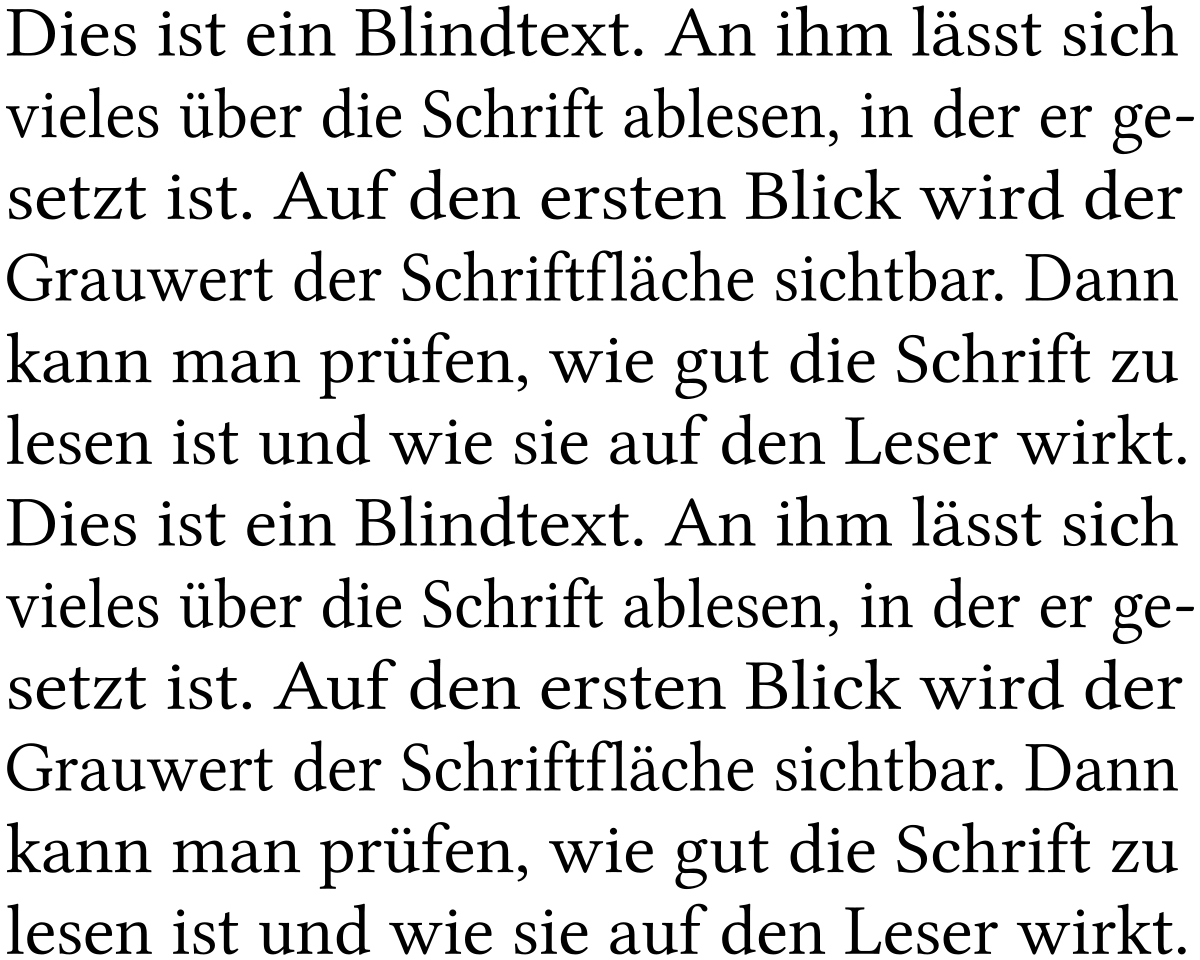

#2. Representação vetorial de textos

Uma vez que apenas números podem ser injetados na camada de entrada de uma rede neural, é preciso codificar a sequência de palavras que formam o texto que será apresentado à rede.

A estratégia mais básica consiste em atribuir um número/código a cada uma das palavras do texto em questão: 

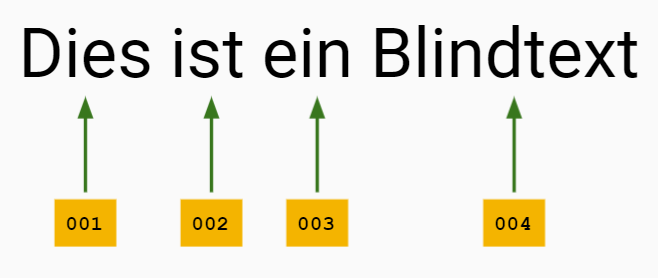

Vamos ao código que cria um dicionário para codificação de texto a partir de um conjunto de sentenças em uma base de treino:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'This is a text',
    'This is a poem',
    'Deep Learning is like poem!'
]

tokenizer = Tokenizer(num_words = 4)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'is': 1, 'this': 2, 'a': 3, 'poem': 4, 'text': 5, 'deep': 6, 'learning': 7, 'like': 8}


A partir de então é possível visualizar a codificação gerada para cada uma das palavras no conjunto de treinamento:

In [ ]:
codes = tokenizer.texts_to_sequences(sentences)
print(codes)

[[2, 1, 3], [2, 1, 3], [1]]


É fato que usaremos o dicionário aprendido na base de treino para codificar os exemplos de teste:

In [ ]:
test_data = ["poem is like text", "Deep learning is pretty easy, just like coding"]

codes = tokenizer.texts_to_sequences(test_data)
print(codes)

[[1], [1]]


No entando, quando uma determinada palavra da query de teste não está presente no vocabulário do treinamento, a codificação fica incompleta.

Ao invés de simplesmente ignorar as palavras *out of vocabulary*, convém criar um código especial para elas. Veja o código que segue:

In [ ]:
tokenizer = Tokenizer(num_words = 100, oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
codes = tokenizer.texts_to_sequences(test_data)

print(word_index)
print(codes)

{'<OOV>': 1, 'is': 2, 'this': 3, 'a': 4, 'poem': 5, 'text': 6, 'deep': 7, 'learning': 8, 'like': 9}
[[5, 2, 9, 6], [7, 8, 2, 1, 1, 1, 9, 1]]


Vemos que frases com mais palavras geram vetores de maior dimensão, e frases com menos palavras geram vetores de menor dimensão.

Para normalizar a dimensionaliddade dos dados, aplicamos o conceito de *padding*:

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(codes, maxlen=10)
print("\nWord Index = " , word_index)
print("\nSequences = " , test_data)
print("\nPadded Sequences:")
print(padded)


Word Index =  {'<OOV>': 1, 'is': 2, 'this': 3, 'a': 4, 'poem': 5, 'text': 6, 'deep': 7, 'learning': 8, 'like': 9}

Sequences =  ['poem is like text', 'Deep learning is pretty easy, just like coding']

Padded Sequences:
[[0 0 0 0 0 0 5 2 9 6]
 [0 0 7 8 2 1 1 1 9 1]]


#3. Aprendendo modelos sequenciais

Ainda não vimos como modelar a ordem de aparição das palavras em uma frase. Por exemplo, $P(``\text{It is quite fine, ok}") \neq (``\text{It is ok, quite fine}")$

Podemos modelar a probabilidade da sequência como a probabilidade de seus componentes condicionados à sequência antecedente, veja:

$P(x_1, x_2,\cdots, x_t) = \prod_{t=1}^T P(x_t|x_1, x_2, \cdots, x_{t-1})$

Por exemplo,

$P(``\text{It}", ``\text{is}", ``\text{quite}", ``\text{fine}") = P(``\text{fine}"|``\text{It}", ``\text{is}", ``\text{quite}") \cdot P(``\text{quite}"|``\text{It}", ``\text{is}")\\ \cdot P(``\text{is}"|``\text{It}")  \cdot P(``\text{It}")$

Umaa estimativa $\hat P(``\text{It}")$ pode ser estimada a partir da frequência de ocorrencia de frases começando com $``\text{It}"$ em uma base de dados. De maneira similar, teríamos:

$ \hat P(``\text{is}"|``\text{It}") = \frac{n(``\text{It}",``\text{is}")}{n(``\text{It}")}$

Provavelmente será bastante complicado encontrar ocorrências suficientes na base para obter estimativas $\hat P$ a partir da combinação de três palavras. Além do mais, qual o custo computacional dessa abordagem inocente?

#4. Redes Neurais Recorrentes

A ideia básica da Rede Neural Recorrente está associada ao surgimento de um *estado escondido* $h$ que permite a seguinte aproximação:

$P(x_t|x_1, x_2, \cdots, x_{t-1}) \approx P(x_t| h_{t-1} )$

Onde o *estado escondido* em qualquer tempo *t* é dado em função da entrada atual $x_t$ e do *estado escondido* anterior $h_{t-1}$:

$h_t = f(x_t,h_{t-1})$

Dessa maneira, o processamento que acontece no neurônio com estado escondido é dado por:

$H_t = g(\omega^0_{hidden} + XW^T + H_{t-1}W_{hidden}^T)$

Veja que $H_t$ é definido recorrentemente em função de $H_{t-1}$. Daí surge a nomenclatura *Rede Neural Recorrente*. Por fim, a computação na camada de saída em cada tempo $t$ é dada por:

$\hat y_t = g(\omega^0_{out} + H_tW_{out}^T)$

Sendo assim, o esquemático da rede neural recorrente é apresentado a seguir: 

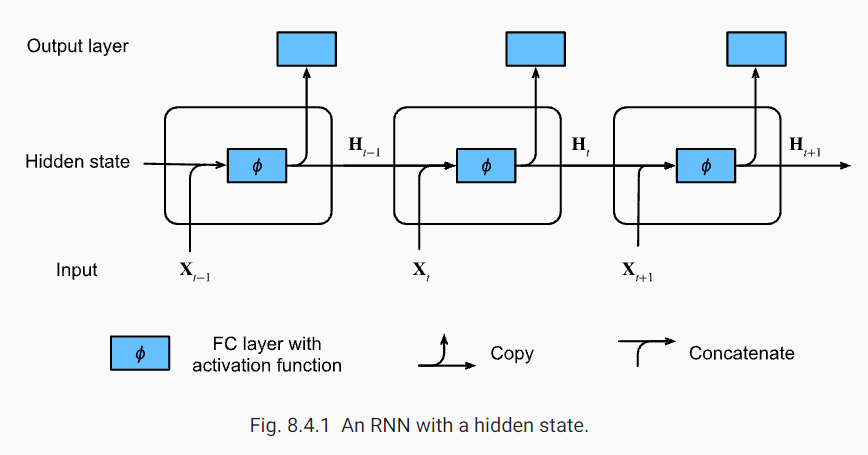

A arquitetura anterior apresenta uma RNN do tipo "many to many" com várias entradas e várias saídas, no entanto - em função do objetivo do problema - pode-se realizar variações dessa arquitetura inicial.

Veja os exemplos a seguir:

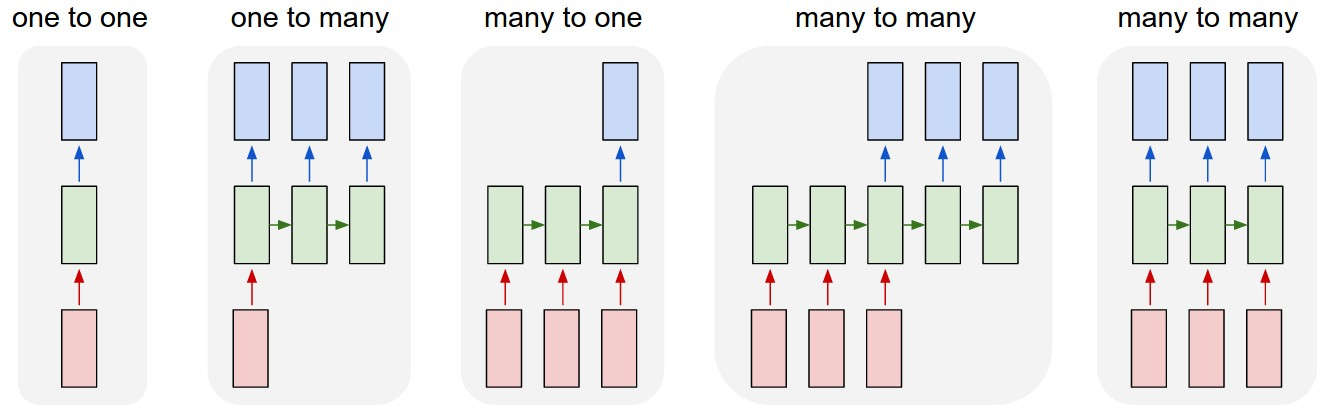

#5. Codificando nossa primeira RNN

O código a seguir é apresentado nas seções 8.3 e 8.5 do livro Dive into Deep Learning.

Inicialmente, o arquivo timemachine.txt contendo o texto de ficção científica *The Time Machine* do autor H. G. Wells é baixado e armazenado no diretório ./data/ da sua máquina virtual colab.

In [ ]:
!pip install matplotlib==2.2.3

!pip install -U d2l
import math
import tensorflow as tf
from d2l import tensorflow as d2l

  Using cached matplotlib-2.2.3-cp37-cp37m-manylinux1_x86_64.whl (12.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 2.2.3 which is incompatible.
arviz 0.11.4 requires matplotlib>=3.0, but you have matplotlib 2.2.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Using cached d2l-0.17.4-py3-none-any.whl (82 kB)
  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x

É possível visualizar todo o texto (organizado como uma lista *Pyhton* de frases) a partir de uma chamada ao método *read_time_machine* da biblioteca *d2l*:

In [ ]:
d2l.read_time_machine()

['the time machine by h g wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller for so it will be convenient to speak of him',
 'was expounding a recondite matter to us his grey eyes shone and',
 'twinkled and his usually pale face was flushed and animated the',
 'fire burned brightly and the soft radiance of the incandescent',
 'lights in the lilies of silver caught the bubbles that flashed and',
 'passed in our glasses our chairs being his patents embraced and',
 'caressed us rather than submitted to be sat upon and there was that',
 'luxurious after dinner atmosphere when thought roams gracefully',
 'free of the trammels of precision and he put it to us in this',
 'way marking the points with a lean forefinger as we sat and lazily',
 'admired his earnestness over this new paradox as we thought it',
 'and his fecundity',
 '',
 'you must follow me carefully i shall have to controvert one or two',
 'ideas that are almost universally accepted the geometry for',
 'instance the

Segue-se a criação do vocabulário baseado na base de dados referente ao livro *The Time Machine*. No código a seguir, as 10 palavras mais frequentes do vocabulário são impressas.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(d2l.read_time_machine())

vocab = tokenizer.word_index
corpus = [x for y in tokenizer.texts_to_sequences(d2l.read_time_machine()) for x in y]

print("vocab: ", vocab)
print("corpus: ", corpus)



vocab:  {'the': 1, 'i': 2, 'and': 3, 'of': 4, 'a': 5, 'to': 6, 'was': 7, 'in': 8, 'that': 9, 'my': 10, 'it': 11, 'had': 12, 'me': 13, 'as': 14, 'at': 15, 'for': 16, 'with': 17, 'but': 18, 'time': 19, 'were': 20, 'this': 21, 'you': 22, 'on': 23, 'then': 24, 'his': 25, 'there': 26, 'he': 27, 'have': 28, 'they': 29, 'from': 30, 'one': 31, 'all': 32, 'not': 33, 'into': 34, 'upon': 35, 'little': 36, 'so': 37, 'is': 38, 'came': 39, 'by': 40, 'some': 41, 'be': 42, 'no': 43, 'could': 44, 'their': 45, 'said': 46, 'saw': 47, 'down': 48, 'them': 49, 'machine': 50, 'which': 51, 'very': 52, 'or': 53, 'an': 54, 'we': 55, 'now': 56, 'what': 57, 'been': 58, 'these': 59, 'like': 60, 'her': 61, 'out': 62, 'seemed': 63, 'up': 64, 'man': 65, 'about': 66, 's': 67, 'its': 68, 'thing': 69, 'again': 70, 'traveller': 71, 'would': 72, 'more': 73, 'white': 74, 'our': 75, 'thought': 76, 'felt': 77, 'when': 78, 'over': 79, 'weena': 80, 'still': 81, 'world': 82, 'myself': 83, 'even': 84, 'must': 85, 'through': 86, 

Para criar uma rede neural que modele as distribuições de probabilidades das sequências de palavras contidas na base de dados. Criamos uma tarefa em que o objetivo é prever o próximo token a partir de uma sequência de $n$ tokens.

In [ ]:
import random
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Iterador que permite o carregamento de subconjuntos parciais dos dados em memória.
    Os dados são carregados em batches, e após o processamento de cada batch os pesos da rede são
    normalmente atualizados segundo o algoritmo backpropagation"""
    # Inicia-se o primeiro batch a partir de um token aleatório do texto
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Calcula-se o numero toda de instâncias/exemplo de tamanho num_seps podem ser criadas
    num_subseqs = (len(corpus) - 1) // num_steps
    # Calcula-se os índices iniciais de cada instância/exemplo que será extraída da base  
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # Embaralha-se a lista de indices iniciais
    random.shuffle(initial_indices)

    def data(pos):
        # retorna-se a instância/exemplo que se inicia no índice pos e contém tamanho num_steps
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # A intrução final 'yield' cria o iterador retornando as saidas X e Y a cada iteracao do 'for' 
        # X contém as instâncias/exemplos de entrada organizadas em batches 
        # Y contém as saídas associadas a cada exemplo em X
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
       
        yield tf.constant(X), tf.constant(Y)

No próximo bloco de código, vemos os tensores de entrada e saída gerados a partir de uma sequência simulada contendo 35 tokens:

**Atenção:** veja que os dados estão organizados em subconjuntos (os batches). A primeira dimensão do tensor representa a dimensão de batch. Esses são os exemplos que serão vistos antes de cada etapa de atualização de pesos do treinamento através do *backprojection*.

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=3, num_steps=4):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[13 14 15 16]
 [17 18 19 20]
 [ 1  2  3  4]], shape=(3, 4), dtype=int32) 
Y: tf.Tensor(
[[14 15 16 17]
 [18 19 20 21]
 [ 2  3  4  5]], shape=(3, 4), dtype=int32)
X:  tf.Tensor(
[[ 5  6  7  8]
 [25 26 27 28]
 [ 9 10 11 12]], shape=(3, 4), dtype=int32) 
Y: tf.Tensor(
[[ 6  7  8  9]
 [26 27 28 29]
 [10 11 12 13]], shape=(3, 4), dtype=int32)


Para facilitar, vamos encapsular tudo isso em um data loader que é instanciado dentro de uma função (*load_data_time_machine*) para inicialização dos dados da base de acordo com um *tamanho de batch* e um *número de estágios temporais*.  

In [ ]:
class SeqDataLoader: 
    """Classe que encapsula o iterator que carrega os batchs de dados em memória """
    def __init__(self, batch_size, num_steps, num_words):
        
        self.data_iter_fn = seq_data_iter_random
        self.tokenizer = Tokenizer(num_words, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(d2l.read_time_machine())
        self.vocab = tokenizer.word_index
        self.corpus = [x for y in tokenizer.texts_to_sequences(d2l.read_time_machine()) for x in y]
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, num_words = 256):
    """Função que retorna o iterator e o vocabulário para manipular a base The Time Machine"""
    data_iter = SeqDataLoader(batch_size, num_steps, num_words)
    return data_iter, data_iter.vocab, data_iter.tokenizer

Para visualizar os batches carregados através do nosso data loader, podemos executar o código a seguir.

Lembre-se que cada valor nos tensores que seguem representa o token de uma palavra no vocabulário!

In [ ]:
num_words, batch_size, num_steps = 512, 32, 15
train_iter, vocab, tokenizer = load_data_time_machine(batch_size, num_steps, num_words)


for X, Y in train_iter:
    print('X: ', X, '\nY:', Y)


X:  tf.Tensor(
[[88  3 13  3 15 90  2  7 37 40 21  4 54  9  2]
 [69 46  1 65 18  2  1  4 59  2 28 49  1 19 71]
 [47 32 22 41 41  8 25 12  1  3  1  8  1 19 71]
 [ 4  1  6  8  1  4 16  2 44 99 43  4  4 18 11]
 [11 16  1 30  6  4 92 13  2  5  4 40  1  7 13]
 [44 33  2 77  2  5  2 77  2 11 22 54 17  3 26]
 [ 1  2 39  6  1  4 30 51  2 12  1 82 35  1  4]
 [ 5  4  1 66  1 36  2 41 19  8 14 14  2  7  6]
 [51  2 12 10 90 60  1 11  7 17  3 40  5 36 30]
 [17  3  5 11  3 26  2 44 99  1  4 68  3 14 11]
 [ 1 17  1  1  6  1 40  4  1 19 71 25  6 25  3]
 [ 4  1  3 43 73 84  9 72  8  1 34  5 55 91 23]
 [ 3 15  1 19 16  1 79 51 59 31 29 30 13 14 11]
 [ 3 26 20  5  4 96  8  1  3  4 49 14  6 13 14]
 [ 2  1 72 42  6 99 13  2  7  4  1 40 41  4 49]
 [ 9  1 17 10 10 20  3 30  1 24  3  8 10  4  2]
 [ 8 18 24 44 11 42  2  2 85 28 12  5  4  2  8]
 [67  2 41  4 22 93  4  1  4  1 19 50  3 22  1]
 [13 24  2 47  1 69  7  5 60 22  5 14 14 17 68]
 [17 49  1  4 10  4  5  3 39 17  6 10  1 12  5]
 [ 1 98  5  3  2 49 92  2

Já vimos anteriormente que não é produtivo iniciar o treinamento de uma rede neural com valores naturais maiores que 1. Dessa forma, usaremos a função *tf.one_hot* para criar uma nova dimensão ao batch de dados com o tantas posições quanto o número de palavras no vocabulário. Nessa nova dimensão, o token da *n-ésima* palavra será assinalado com o valor 1 na posição *n*.

In [ ]:
newX = tf.one_hot(X, num_words)
print('X: ', X.shape, '\nONE HOT X:', newX.shape)

X:  (32, 15) 
ONE HOT X: (32, 15, 512)


A partir daqui, veremos duas implementações para nossa primeira RNN: **5.1.** Implementação do zero, e **5.2.** Implementação usando o Keras.

##5.1 Implementação do zero

Implementaremos a célula de recorrência ilustrada a seguir em que:

  * $\mathbf{H}^{(t-1)}$ é estado escondido anterior de tamanho $h$,
  * $\mathbf{W}_{hh}$ é a matriz de pesos que processa o estado escondido anterior, 
  * $\mathbf{W}_{xh}$ é a matriz de pesos que processa uma nova entrada de tamanho $L$, 
  * $\mathbf{bh}$ é o bias que ajuda a gerar o estado escondido atual,  
  * $\mathbf{W}_{hq}$ é a matriz de pesos que gera a saída atual,
  * $\mathbf{bq}$ é o bias que ajuda a gerar a saída atual,  

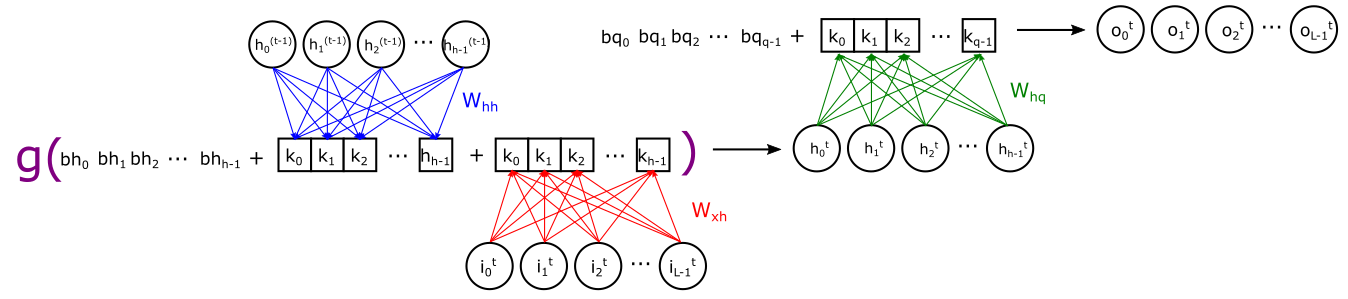

In [ ]:
def get_params(vocab_size, num_hiddens): 
    """inicializa os parametros de uma celula de recorrencia"""
    num_inputs = num_outputs = vocab_size #entrada e saida contem vocab_size neurônios (lembrar que as palavras estão codificadas pelo padrão one hot encoding)

    def normal(shape):
        return tf.random.normal(shape=shape, stddev=0.01, mean=0,
                                dtype=tf.float32)

    # Parâmetros para manipular o estado escondido
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Parâmetros para manipular a saída da celula de recorrencia
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

def init_rnn_state(batch_size, num_hiddens): #retorna o primeiro estado escondido (cujo valor é zero)
    return (tf.zeros((batch_size, num_hiddens)),)

def rnn(inputs, state, params):
    """Calcula o estado escondido e da saida da RNN após a execução sequencial da célula de recorrencia por num_steps ciclos"""
    # O formato do tensor 'inputs': (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # formato do tensor `X`: (`batch_size`, `vocab_size`)
    for X in inputs: #repeticao acontece por 'num_steps' vezes
        X = tf.reshape(X, [-1, W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        #as saídas após cada passo da recorrência são acumuladas em um vetor de saída
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,) #todas as saídas parciais são concatenadas na dimensão 0 do tensor resultante, e uma tupla contendo uma única estrutura retorna o último estado escondido

class RNNModelScratch: 
    """Classe que encapsula todo o código da nossa RNN"""
    def __init__(self, vocab_size, num_hiddens, init_state, forward_fn,
                 get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)

    def __call__(self, X, state):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        #print(">>",X.shape)
        return self.forward_fn(X, state, self.trainable_variables)

    def begin_state(self, batch_size, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

Para checar a implementação em detalhes, vamos checar as dimensões dos vetores relacionados a uma execução da RNN.

In [ ]:
num_hiddens = 512 #tamanho selecionado para o estado escondido

net = RNNModelScratch(num_words, num_hiddens, init_rnn_state, rnn, get_params) #inicialização da classe que encapsula a RNN
state = net.begin_state(X.shape[0]) #Inicialização do primeiro estado escondido passando como parâmetro o batch size (veja que a primeira dimensao do tensor X é exatamente o batch size)
pred, new_state = net(X, state) #execução da RNN passando como entrada um batch contendo batch_size exemplos de frases com num_steps palavras e onde cada palavra é representada por len(vocab) neuronios 
pred.shape, len(new_state), new_state[0].shape #dimensoes esperadas: (saída da rede) pred [batch_size*num_steps, num_words], (estado escondido) [batch_size, num_hiddens]

(TensorShape([480, 512]), 1, TensorShape([32, 512]))

###Os pesos da rede são capazes de gerar as próximas palavras de um frase!

O conjunto de pesos da rede *armazena implicitamente as distribuições de probabilidade de sequências de palavras aprendidas de um conjunto de treinamento*. Porém, antes mesmo de realizar o treinamento da rede, podemos executar a rede com o conjunto inicial de pesos gerados na inicialiazção aleatória.

Para isso, codificamos a seguinte função *predict*:

In [ ]:
def predict(prefix, num_preds, net, vocab, token_param): 
    """Etapa de predição gera novas palavras a partir de um texto inicial em 'prefix' """
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix.split()[0]]]
    #print(outputs)
    #print(state.shape)
    #print('Warming up the recurrent cell: ', outputs)
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix.split()[1:]:  # Etapa de aquecimento em que as palavras iniciais vão sendo apresentadas à celula de recorrencia (saídas por enquanto são desconsideradas)
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
        #print(outputs)
        #print('Warming up the recurrent cell: ', outputs)
    
    for _ in range(num_preds):  # Etapa de predição executada chamadas a célula de recorrência 'num_preds' vezes
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
        #print(outputs)
        #print('Firing the recurrent cell:', outputs)
    return token_param.sequences_to_texts([outputs])

Em seguida, podemos usar *predict* para gerar 5 palavras após uma sequência inicial.

**obs.:** enquanto a rede não está treinada, não é esperada nenhuma lógica nas palavras geradas!

In [ ]:
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(d2l.read_time_machine())

vocab = tokenizer.word_index
corpus = [x for y in tokenizer.texts_to_sequences(d2l.read_time_machine()) for x in y]

predict('the man is quite', 8, net, vocab, tokenizer)
#print(tokenizer.sequences_to_texts([[79]]))


['the man is quite odd over imagine travelled hesitated between man came']

O código que segue permite o treinamendo dos pesos da rede.

Para mais detalhes, siga os comentários no código.

In [ ]:
def grad_clipping(grads, theta): #função auxiliar que imiplementa um artifício matemático para gradiente não 'explodir'
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(
        sum((tf.reduce_sum(grad**2)).numpy() for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

def train_epoch(net, train_iter, loss, updater):
    """Função chamada a cada época para atualizar os pesos do modelo em função dos exemplos em um mesmo batch"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  
    for X, Y in train_iter:
        if state is None:
            # Inicialização do primeiro estado escondido com zeros
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g: #fita usada para gravar internamente a cadeia de gradientes 
            y_hat, state = net(X, state) #execução da rede com todas as amostras do batch. Usa-se o estado escondido anterior para atualizar o estado escondido atual.
            y = tf.reshape(tf.transpose(Y), (-1))  
            y = tf.one_hot(y, net.vocab_size)
            y = tf.cast(y, tf.float32)          
            l = loss(y, y_hat) #calculo do erro
        params = net.trainable_variables
        grads = g.gradient(l, params) #calcula a derivada parcial do gradiente em relação a todos os parâmetros treináveis da rede
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params)) #aplica-se os gradientes calculados para atualização dos pesos da rede
        metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train(net, train_iter, vocab, lr, num_epochs):
    """Treinamento da rede em 'num_epochs' epocas"""
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 5, net, vocab, tokenizer))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller', 5, net, vocab, tokenizer))
    print(predict('traveller', 5, net, vocab, tokenizer))

KeyboardInterrupt: ignored

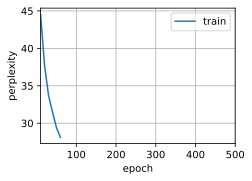

In [ ]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs)

##5.2 Implementação usando o framework Keras

A implementação da RNN através das funcionalidades do framework Keras se dá através da:

  * célula de recorrência implementada através da classe *tensorflow.keras.layers.SimpleRNNCell*
  * lógica de recorrência implementada através da classe *tensorflow.keras.layers.RNN*

In [ ]:
num_hiddens, batch_size, vocab_size = 512, 32, 256

rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True, return_sequences=True, return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer #RNN criado anteriormente
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        Y, state = self.rnn(X, state)
        # The fully-connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1]))) #saida da celula gerada pela celula RNN é processada por uma camada densamente conectada 
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

net = RNNModel(rnn_layer, vocab_size=vocab_size)


Após a definição e instanciamento da rede, podemos usar as funções definidas anteriormente para realizar uma nova predição...

In [ ]:
predict('time traveller', 10, net, vocab, tokenizer)


['but again perhaps eyes cannot moon indeed something up say flowers moment']

... e um novo treinamento:

In [ ]:
num_epochs, lr = 1000, 1
train(net, train_iter, vocab, lr, num_epochs)

NameError: ignored

#6. A Unidade de Recorrência baseada em Portões (GRU, *Gated Recurrent Unit*)

A GRU é uma **célula de recorrência especial** em que algumas partes do estado escondido anterior podem ser **esquecidos parcialmente**. Sendo assim, os novos estados escondidos são **atualizados parcialmente**. Sendo assim, os trechos mais importantes do estado escondido podem se propagar por longas cadeias de recorrência.

Matematicamente, os sinais internos da GRU que permitem os comportamentos descritos anteriormente são os seguintes:

  * $R_t = \sigma(X_t W_{xr} + H_{t-1} W_{hr} + b_r)$
  * $Z_t = \sigma(X_t W_{xz} + H_{t-1} W_{hz} + b_z)$
  * $\tilde H_t = tanh(R_t \odot H_{t-1} + X_t W_{xh} + b_h)$
  * $H_t = Z_t \odot H_{t-1} + (1-Z_t) \odot \tilde H_t$


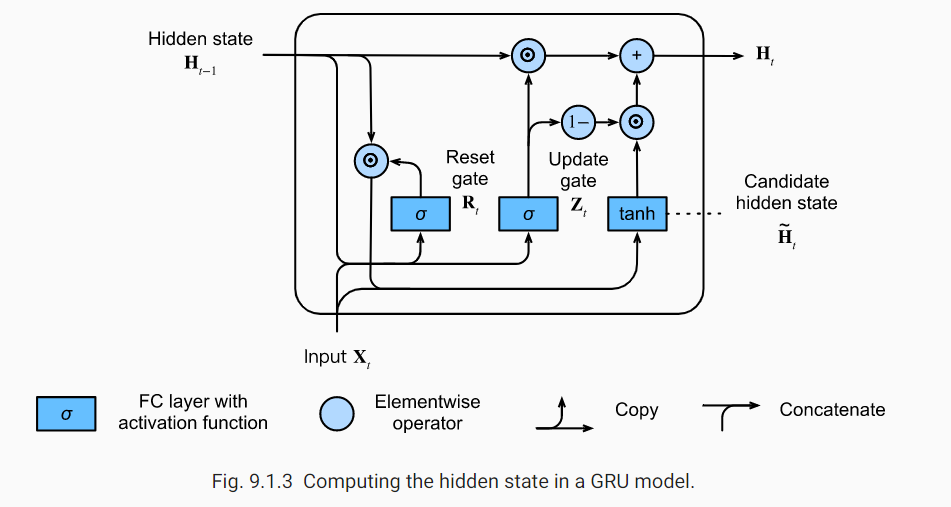

In [ ]:
gru_cell = tf.keras.layers.GRUCell(num_hiddens, kernel_initializer='glorot_uniform')
gru_layer = tf.keras.layers.RNN(gru_cell, time_major=True, return_sequences=True, return_state=True)

class GRUModel(tf.keras.layers.Layer):
    def __init__(self, gru_layer, vocab_size, **kwargs):
        super(GRUModel, self).__init__(**kwargs)
        self.rnn = gru_layer #GRU criado anteriormente
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        Y, state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1]))) #saida da celula gerada pela celula RNN é processada por uma camada densamente conectada 
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

gru = GRUModel(gru_layer, vocab_size=vocab_size)

train(gru, train_iter, vocab, lr, num_epochs)

#7. Memória de Longo e Curto Prazo (LSTM, *Long Short Term Memory*)

A LSTM é uma segunda **célula de recorrência especial** em existe um número maior de portões para controlar o fluxo de informação: o portão de entrada, o portão de saída, e o portão de esquecimento. Existe agora, além do estado escondido, uma célula de memória que viaja através da sequência visando trazer informações sequencias de eventos mais distantes (Long Term Memory).


Matematicamente, os sinais internos da LSTM que permitem os comportamentos descritos anteriormente são os seguintes:

  * $I_t = \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i)$
  * $F_t = \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f)$
  * $O_t = \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)$
  * $\tilde C_t = tanh(X_t W_{xc} + H_{t-1} W_{xc} + b_c)$
  * $C_t = F_t \odot C_{t-1} + I_t \odot \tilde C_t$
  * $H_t = O_t \odot tanh(C_t)$ 


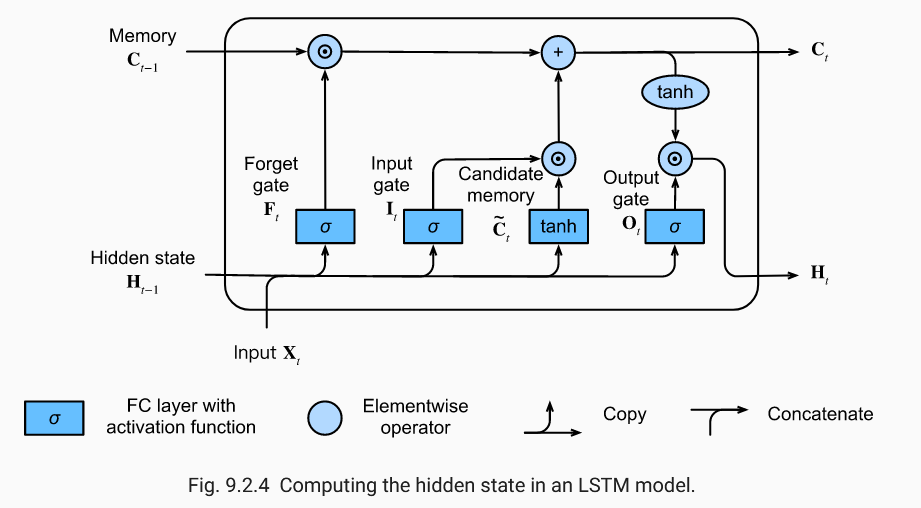

In [ ]:
lstm_cell = tf.keras.layers.LSTMCell(num_hiddens, kernel_initializer='glorot_uniform')
lstm_layer = tf.keras.layers.RNN(lstm_cell, time_major=True, return_sequences=True, return_state=True)

class LSTMModel(tf.keras.layers.Layer):
    def __init__(self, lstm_layer, vocab_size, **kwargs):
        super(LSTMModel, self).__init__(**kwargs)
        self.rnn = lstm_layer #LSTM criado anteriormente
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        Y, state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1]))) #saida da celula gerada pela celula RNN é processada por uma camada densamente conectada 
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

lstm = LSTMModel(gru_layer, vocab_size=vocab_size)

train(lstm, train_iter, vocab, lr, num_epochs)